# Interactive Weak Supervision for NLP

## Lesson 1: Foundational Weak Supervision

1. The labeling problem
2. Some alternatives to hand labeling
3. What is weak supervision?
4. Implement a simple weakly supervised system

3 key figures that a data scientist or subject matter expert (SME) can leverage in order to gauge the performance of probabilistic models and use the performance as encoded by the figures to iterate on the model:

Base rate distribution,
Probabilistic confusion matrix, and
Label prediction distribution.

The first step in the workflow is to hand label a small sample of the data. The data we'll be working with here is the medical transcriptions dataset from Kaggle and the task is to predict whether any given transcription involved surgery, as given in the 'medical specialty' column. We'll use this column to hand label several rows, for pedagogical purposes, but this will usually be an SME looking through the transcription to label the rows. Let's jump in and have a look at our data:

In [16]:
# import packages and data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
sns.set()
df = pd.read_csv('data/mtsamples.csv')
df.head()

,Description,Medical_specialty,Sample_name,transcription
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr..."
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb..."
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ..."
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...


Having checked out our data, let's simulate some hand labeled rows by using the `Medical_specialty` column

In [17]:
# hand label some rows
N = 250
df = df.sample(frac=1, random_state=42).reset_index()
df_labeled = df.iloc[:N]
df_unlabeled = df.iloc[N:]
df_labeled['label'] = (df_labeled['Medical_specialty'].str.contains('Surgery') == 1).astype(int)
df_unlabeled['label'] = None
df_labeled.head()

,index,Description,Medical_specialty,Sample_name,transcription,label
0,84,An example/template for meatotomy.,Urology,Meatotomy Template,"OPERATIVE NOTE: ,The patient was taken to the...",0
1,2470,Normal physical exam template. Normal appear...,Office Notes,Normal Physical Exam Template - 6,"VITAL SIGNS:, Reveal a blood pressure of *, t...",0
2,2804,Neurologic consultation was requested to asse...,Neurology,Neurologic Consultation - 3,"HISTORY: , Neurologic consultation was request...",0
3,4987,"Multiple sharp force injuries, involving ches...",Autopsy,Autopsy - 6,"ANATOMICAL SUMMARY,1. Sharp force wound of nec...",0
4,4924,The patient with atypical type right arm disc...,Cardiovascular / Pulmonary,Cardiac Catheterization - 2,"INDICATIONS FOR PROCEDURE:, The patient has pr...",0


These acts of hand labeling serve two purposes:

1. to teach us about the class balance and base rate
2. to create a small validation set

When building our label model, it will be key to make sure that the model at least approximately respects the class balance, as encoded in the base rate of these hand labels, so lte's calculate the base rate now.

In [18]:
base_rate = sum(df_labeled['label'])/len(df_labeled)
f"Base rate = {base_rate}"

'Base rate = 0.24'

### The Base Rate Distribution

It's now time to introduce the first key figure: the **base rate distribution**. What do we mean by "distribution" here, given that that we have an actual base rate? Well, one way to think about it is that we've calculated the base rate from a sample of the data. This means that we don't know the exact base rate and our uncertaintly around it can be characterized by a distribution. One technical way to formulate this uncertaintly is using Bayesian techniques and, essentially, our knowledge about the base rate is encoded by the posterior distribution. You don't need to know too much about Bayesian methods to get the gist of this, but if you'd like to know more, you can check out some introductory material [here](https://github.com/ericmjl/bayesian-stats-modelling-tutorial). Below, we write a function that plots the **base rate distribution** and we then plot the distribution for the data we hand labeled above.


In [19]:
def plot_posterior(df, xlabel, ylabel):
    """Plot the posterior given a uniform prior; data df"""
    # Amount of data
    N = len(df)

    # Flip coins 
    n_successes = df.label.sum()
    
    # X-axis for PDF
    x = np.linspace(0, 1, 100)
    
    # Write out equation for uniform prior
    prior = np.ones(len(x))
    
    # Write out equation for posterior, which is likelihood * prior.
    posterior = (x**n_successes) * ((1-x)**(N-n_successes)) * prior
    
    # Pseudo-normalize the posterior so that we can compare them on the same scale.
    posterior /= np.max(posterior)  
    
    # Plot posterior
    plt.plot(x, posterior)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

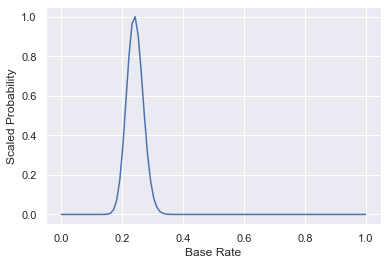

In [20]:
# plot base rate distribution
# to do: include axis labels etc...
plot_posterior(df_labeled, 'Base Rate', 'Scaled Probability')


First note the the peak of the distribution is at the base rate we calculated, meaning that this is the most likely base rate. However, the spread in the distribution also captures our uncertainty around the base rate.

It is essential to keep an eye on this figure as we iterate on our model, as any model will need to predict a base rate that is close to the peak of the base rate distribution.

Note that 

- as you generate more and more data, your posterior gets narrower, i.e. you get more and more certain of your estimate.
- you need more data to be certain of your estimate when $p=0.5$, as opposed to when $p=0$ or $p=1$.

To see these, play around with interact widget below, by altering $p$ and $N$ for a biased coin flip:

In [21]:
def plot_posterior_flip(p=0.6, N=0):
    """Plot the posterior given a uniform prior; Bernoulli trials
    with probability p; sample size N"""
    np.random.seed(42)
    # Flip coins 
    n_successes = np.random.binomial(N, p)
    # X-axis for PDF
    x = np.linspace(0, 1, 100)
    # Prior
    prior = 1
    # Compute posterior, given the likelihood (analytic form)
    posterior = x**n_successes*(1-x)**(N-n_successes)*prior
    posterior /= np.max(posterior)  # so that peak always at 1
    plt.plot(x, posterior)
    plt.xlabel('p')
    plt.ylabel('N')

In [22]:
from ipywidgets import interact
interact(plot_posterior_flip, p=(0, 1, 0.01), N=(0, 1500));

interactive(children=(FloatSlider(value=0.6, description='p', max=1.0, step=0.01), IntSlider(value=0, descript…

### Programmatic Labeling with Domain Hinters

Having hand labeled a subset of the data and calculated the base rate, it's time to get the machine to do some probabilistic labeling for us, using some domain expertise. 

A doctor, for example, may know that, if the transcription includes the term 'ANESTHESIA', then it's quite likely that surgery occurred. This type of knowledge, once encoded for computation, is known as a hinter, or a Labeling Function.

We can use this information to build a model in several ways, including building a generative model, which we'll do soon. For simplicity's sake, as a first approximation we'll update the probabilistic labels by 

* increasing P(Surgery) from the base rate if the transcription includes the term 'ANESTHESIA' and 
* doing nothing if it doesn't (we're assuming that the absence of the term provides no signal here). 

There are many ways to increase P(Surgery) and, for simplicity, we take the average of the current P(Surgery) and a weight W (the weight is usually specified by the SME and encodes how confident they are that the hinter is correlated with positive results).


In [23]:
# Combine labeled and unlabeled to retrieve our entire dataset
df1 = pd.concat([df_labeled, df_unlabeled])

# Check out how many rows contain the term of interest
df1['transcription'].str.contains('ANESTHESIA').sum()

1319

In [24]:
# Create column to encode hinter result
df1['h1'] = df1['transcription'].str.contains('ANESTHESIA')
## Hinter will alter P(S): 1st approx. if row is +ve wrt hinter, take average; if row is -ve, do nothing
## OR: if row is +ve, take average of P(S) and weight; if row is -ve
##
## Update P(S) as follows
## If h1 is false, do nothing
## If h1 is true, take average of P(S) and weight (95), unless labeled
W = 0.95
L = []
for index, row in df1.iterrows():
    if  df1.iloc[index]['h1']:
        P1 = (base_rate + W)/2
        L.append(P1)
    else:
        P1 = base_rate
        L.append(P1)
df1['P1'] = L
# Check out what our probabilistic labels look like
df1.P1.value_counts()

0.240    3647
0.595    1352
Name: P1, dtype: int64

Now that we've updated our model using a hinter, let's drill down into how our model is performing. The two most important things to check are
1. How our probabilistic predictions match up with our hand labels and
2. How our label distribution matches up with what we know about the base rate.

For the former question, enter the probabilistic confusion matrix.

### The Probabilistic Confusion Matrix

In a classical confusion matrix, one axis is your hand labels and the other access is the model prediction. 
In a probabilistic confusion matrix, your y axis is your hand labels and the x axis is model prediction. But in this case, the model prediction is a probability, as opposed to 'yes' or 'no', in the classical confusion matrix.

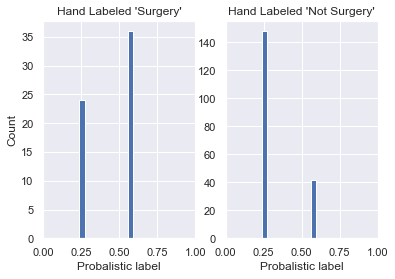

In [26]:
plt.subplot(1, 2, 1)
df1[df1.label == 1].P1.hist();
plt.xlabel("Probalistic label")
plt.ylabel("Count")
plt.title("Hand Labeled 'Surgery'")
plt.xlim([0, 1])
plt.subplot(1, 2, 2)
df1[df1.label == 0].P1.hist();
plt.xlabel("Probalistic label");
plt.title("Hand Labeled 'Not Surgery'");
plt.xlim([0, 1]);

We see here that
- The majority of data labeled 'Surgery' has P(S) around 0.60 (though not by much) and the rest around 0.24;
- All rows hand labeled 'Not Surgery' have P(S) around 0.24 and the rest around 0.60.

This is a good start, in that P(S) is skewed to the left for those label 'Not Surgery' and to the right for those labeled 'Surgery'. However, we would want it skewed far closer to P(S) = 1 for those label Surgery so there's still work to be done.

### Label Distribution Plot

The next key plot is the label prediction distribution plot across the dataset: we want to see how our label predictions are distributed and whether this matches up to what we know of our base rate. For example, in our case, we know that our base rate is likely somewhere around 25%. So what we would expect to see in the label distribution is ~25% of our dataset with a near 100% chance of being surgery and ~75% of it with a low chance of being surgery.

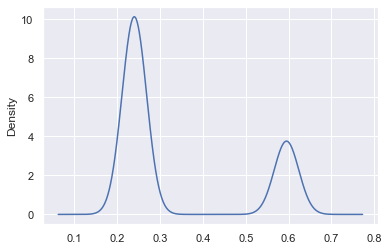

In [30]:
df1.P1.plot.kde();



We see peaks at ~25% and ~60%, which means that our model really doesn't yet have a strong sense of the label and so we want to add more hinters.
Essentially, we'd really like to see our probabilistic predictions closer to ) and 1, in a proportion that respects the base rate.

### Building more hinters

To build better labels, we can inject more domain expertise by adding more hinters. We do this below by adding two more positive hinters (ones that are correlated with 'Surgery'), which alter our predicted probability in a manner analogous to the hinter above.

In [31]:
# Create column to encode hinter result
df1['h2'] = df1['transcription'].str.contains('psych')
## Hinter will alter P(S): 1st approx. if row is +ve wrt hinter, take average; if row is -ve, do nothing
## OR: if row is +ve, take average of P(S) and weight; if row is -ve
##
## Update P(S) as follows
## If h1 is false, do nothing
## If h1 is true, take average of P(S) and weight (95), unless labeled
W = 0.95
L = []
for index, row in df1.iterrows():
    if  df1.iloc[index]['h2']:
        P2 = (df1.iloc[index]['P1'] + W)/2
        L.append(P2)
    else:
        P2 = df1.iloc[index]['P1']
        L.append(P2)
df1['P2'] = L

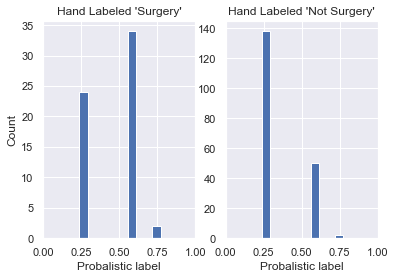

In [32]:
plt.subplot(1, 2, 1)
df1[df1.label == 1].P2.hist();
plt.xlabel("Probalistic label")
plt.ylabel("Count")
plt.title("Hand Labeled 'Surgery'")
plt.xlim([0, 1])
plt.subplot(1, 2, 2)
df1[df1.label == 0].P2.hist();
plt.xlabel("Probalistic label")
plt.title("Hand Labeled 'Not Surgery'");
plt.xlim([0, 1]);

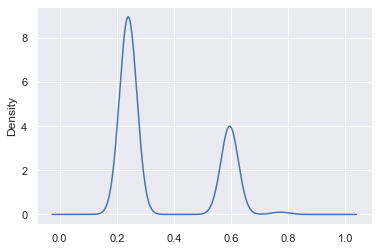

In [33]:
df1.P2.plot.kde();

In [34]:
# Create column to encode hinter result
df1['h3'] = df1['transcription'].str.contains('sponge')
## Hinter will alter P(S): 1st approx. if row is +ve wrt hinter, take average; if row is -ve, do nothing
## OR: if row is +ve, take average of P(S) and weight; if row is -ve
##
## Update P(S) as follows
## If h1 is false, do nothing
## If h1 is true, take average of P(S) and weight (95), unless labeled
W = 0.95
L = []
for index, row in df1.iterrows():
    if  df1.iloc[index]['h3']:
        P3 = (df1.iloc[index]['P2'] + W)/2
        L.append(P3)
    else:
        P3 = df1.iloc[index]['P2']
        L.append(P3)
df1['P3'] = L

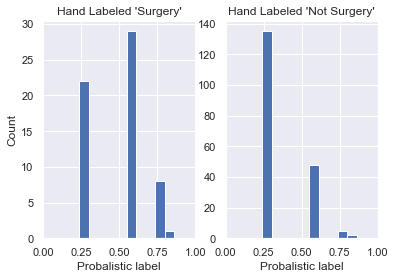

In [35]:
plt.subplot(1, 2, 1)
df1[df1.label == 1].P3.hist();
plt.xlabel("Probalistic label")
plt.ylabel("Count")
plt.title("Hand Labeled 'Surgery'")
plt.xlim([0, 1])
plt.subplot(1, 2, 2)
df1[df1.label == 0].P3.hist();
plt.xlabel("Probalistic label")
plt.title("Hand Labeled 'Not Surgery'");
plt.xlim([0, 1]);

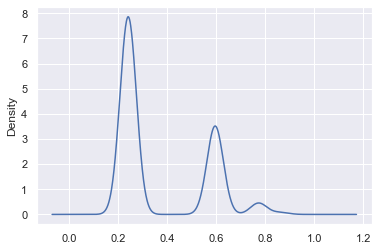

In [36]:
df1.P3.plot.kde();

Two things have happened, as we increased our number of hinters:

1. In our probabilistic confusion matrix, we've seen the histogram for those hand labeled 'Surgery' move to the right, which is good! We've also seen the histogram for hand labeled 'Surgery' move slightly to the right, which we don't want. Note that this is because we have only introduced positive hinters so we may want to introduce negative hinters next or use a more sophisticated method of moving from hinter to probabilistic labels.
2. Our label distribution plot now has more density above P(S) = 0.5 (more density on the right), which is also desirable. Recall what we would expect to see in the label distribution is ~25% of our dataset with a near 100% chance of being surgery and ~75% of it with a low chance of being surgery.

### Learning a Generative Model for P-Labels

Such hinters, although instructive as toy examples, can only be so performant. Let's now use a larger set of hinters to see how if we can build better training data.

We'll also use a more sophisticated method of moving from hinter to probabilistic label: instead of averaging over a weight and previous probabilistic prediction, we'll use a Naive Bayes model, which is a generative model. A generative model is one that models the _joint probability_ $P(X, Y)$ of features $X$ and target $Y$, in contrast to discriminative models that model the conditional probability $P(Y|X)$ of the target conditional on the features. A strength of using a generative model, as opposed to a discriminative model like a random forest, is that it allows us to model the complex relationships between the dat, the target variable, and the hinters: it allows us to answer questions such as "Which hinters are noisier than the others?" and "In which cases are they noisy?" For more on generative models, Google has a nice introduction [here](https://developers.google.com/machine-learning/gan/generative).

To do this, we create arrays that encode whether or not a hinter is present, for any given row. First, let's create lists of positive and negative hinters:

In [37]:
# List of positive hinters
pos_hinters = ['anesthesia', 'subcuticular', 'sponge', 'retracted', 'monocryl', 'epinephrine', 
           'suite', 'secured', 'nylon', 'blunt dissection', 'irrigation', 'cautery', 'extubated', 
           'awakened', 'lithotomy', 'incised', 'silk', 'xylocaine', 'layers', 'grasped', 'gauge', 
           'fluoroscopy', 'suctioned', 'betadine', 'infiltrated', 'balloon', 'clamped']
# List of negative hinters
neg_hinters = ['reflexes', 'pupils', 'married', 'cyanosis', 'clubbing', 'normocephalic', 'diarrhea', 'chills', 'subjective']

For each hinter, we now create a column in the DataFrame encoding whethere the teerm is in the transcription of that row:

In [38]:
for hinter in pos_hinters:
    df1[hinter] = df1['transcription'].str.contains(hinter, na=0).astype(int)
    # print(df1[hinter].sum())
for hinter in neg_hinters:
    df1[hinter] = -df1['transcription'].str.contains(hinter, na=0).astype(int)
    # print(df1[hinter].sum())

We now convert the **labeled data** into NumPy arrays and split it into training and validation sets, in order to train our probabilistic predictions on the former and test them on the latter (note we're currently using only positive hinters).

In [39]:
# extract labeled data
df_lab = df1[~df1['label'].isnull()]
#df_lab.info()
# convert to numpy arrays
X = df_lab[pos_hinters].to_numpy()
y = df_lab['label'].to_numpy().astype(int)
## split into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
       X, y, test_size=0.33, random_state=42)

We now train a [(Bernoulli or Binary) Naive Bayes algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html) on the training data:

In [41]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB(class_prior=[base_rate, 1-base_rate])
clf.fit(X_train, y_train);

With this trained model, let's now make our probabilistic prediction on our validation (or test) set and visualize our probabilistic confusion matrix to compare our predictions with our hand labels:

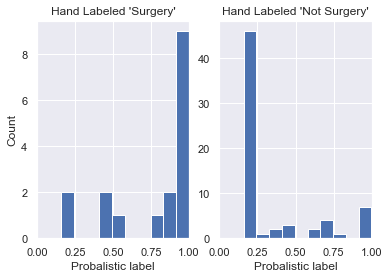

In [42]:
probs_test = clf.predict_proba(X_test)
df_val = pd.DataFrame({'label': y_test, 'pred': probs_test[:,1]})
plt.subplot(1, 2, 1)
df_val[df_val.label == 1].pred.hist();
plt.xlabel("Probalistic label")
plt.ylabel("Count")
plt.title("Hand Labeled 'Surgery'")
plt.xlim([0, 1])
plt.subplot(1, 2, 2)
df_val[df_val.label == 0].pred.hist();
plt.xlabel("Probalistic label")
plt.title("Hand Labeled 'Not Surgery'");
plt.xlim([0, 1]);

This is cool! Using more hinters and a Naive Bayes model, we see that we've managed to increase the number of true positives _and_ true negatives. This is visible in the plots above as the histogram for the hand label 'Sugery' is skewed more to the right and the histogram for 'Not Surgery' to the left.

Now let's plot the entire label distribution plot:

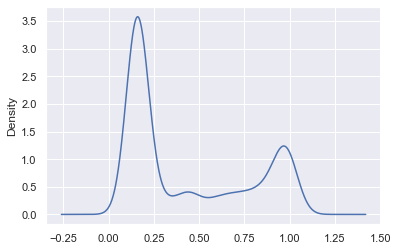

In [43]:
probs_all = clf.predict_proba(df1[pos_hinters].to_numpy())
df1['pred'] = probs_all[:,1]
df1.pred.plot.kde();

This is a significant improvement to our previous labels, as we have far more density closer to 1. Let's now see if we can make any performance gains adding in the negative hinters.

In [44]:
# extract labeled data
df_lab = df1[~df1['label'].isnull()]
#df_lab.info()
# convert to numpy arrays
X = df_lab[pos_hinters + neg_hinters].to_numpy()
y = df_lab['label'].to_numpy().astype(int)

## split into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
       X, y, test_size=0.33, random_state=42)

# Time to Naive Bayes that shit!
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB(class_prior=[base_rate, 1-base_rate])
clf.fit(X_train, y_train);

Let's plot the probabilistic confusion matrix and the label distribution plot:

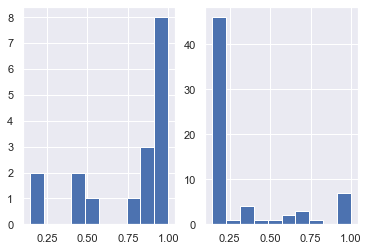

In [45]:
probs_test = clf.predict_proba(X_test)
df_val = pd.DataFrame({'label': y_test, 'pred': probs_test[:,1]})
plt.subplot(1, 2, 1)
df_val[df_val.label == 1].pred.hist();
plt.subplot(1, 2, 2)
df_val[df_val.label == 0].pred.hist();

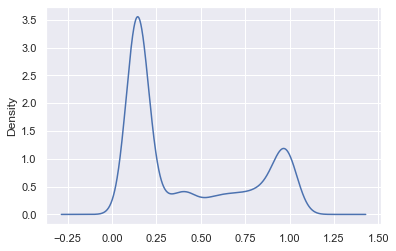

In [46]:
probs_all = clf.predict_proba(df1[pos_hinters + neg_hinters].to_numpy())
df1['pred'] = probs_all[:,1]
df1.pred.plot.kde();

## Lesson 2: Probabilistic Weak Label Evaluation
5. How do I evaluate label quality?
6. How do I train a model with this data?

## Lesson 3: Weak Signal Generation
7. How do I generate more sources of weak signal?